# Micro Climate Predictions with Nearby Weather Stations

It helps infer weather forecasts for stations that have no data or limited data by utilizing data of neighboring stations. The notebook demonstrates configuring inputs and training a model using neighboring weather stations data.

This is an extension of the deepmc notebook [notebooks/deepmc/mc_forecast.ipynb](https://github.com/microsoft/farmvibes-ai/blob/main/notebooks/deepmc/mc_forecast.ipynb).

Before running this notebook, let's build a micromamba environment. If you do not have micromamba installed, please follow the instructions from the [micromamba installation guide](https://mamba.readthedocs.io/en/latest/installation/micromamba-installation.html).

```bash
$ micromamba env create -f ./deepmc_neighbors_env.yaml
$ micromamba activate deepmc-pytorch-neighbors
```

**Install Packages**

In [1]:
! pip install torch==1.12.1 --index-url https://download.pytorch.org/whl/cpu
! pip install torch-scatter==2.1.0 torch-sparse==0.6.15 torch-geometric==2.3.0 -f https://data.pyg.org/whl/torch-1.12.1%2Bcpu.html
! pip install torch-geometric-temporal~=0.54.0 onnxruntime~=1.15.0 pytorch-lightning~=1.8.0

## Notebook overview
In this notebook, we describe steps to generate forecast for weather variables at a specific station with no or limited data. We employ [Graphical Neural Network (GNNs)](https://pytorch-geometric.readthedocs.io/) for cross-learning from nearby weather stations by capturing spatial relationships. 

To illustrate this approach, we focus on three locations in Washington state, U.S.A., utilizing data accessible through [AGWeatherNet](https://weather.wsu.edu/). An example is shown the figure below. For instance, assuming that the Warden SW station has missing data, we look to neighboring stations (such as Royal Slope and Ringold) that provide relevant data. We consider the weather variables, temperature, humidity and wind_speed.

<img src="graph.svg">

Selecting appropriate neighboring stations is crucial for accurate predictions. When choosing neighboring weather stations, consider the following factors:

- Elevation Similarity: In the current model the neighboring stations should be at a similar elevation to the target station. This ensures that altitude-related effects are consistent. Although, one can build a edge weight model which includes altitude differential to accommodate for the topography (this notebook does not cover that). 

- Spatial Proximity: The distance between neighboring stations should be small. Proximity often implies similar local weather patterns. For example, in the example, we chose stations with distance less than 25 km between them. In our experiments we noticed significant errors with distances greater than 25 Kms.

**Graph Representation of Weather Stations for GNNs**

Each weather station corresponds to a node in our graph. To capture the relationships between stations, we connect stations based on the distance between them. This graph does not change with time during inference. If a new station is available which can be helpful to increase accuracy, then the model can be dynamically updated by recomputing & retraining the GNN.


Following steps are required for training a model and inference.

**Step 1: Download AgWeatherNet data**
- Download historical weather data for the stations Royal Slope and Ringold from [AGWeatherNet]( https://weather.wsu.edu/) for the time range of interest (minimum 2 years of data).
- Clean downloaded historical data for considered variables temperature, humidity and wind_speed. 

Note: these two steps are not included in the notebook. See [sample data](sample_data.csv) for an example. 

**Step 2: Download forecast data**
- Download HRRR data for the stations Warden SW, Royal Slope and Ringold using herbie_forecast workflow in Farmvibes for the time range of interest (minimum 2 years of data).
- Clean downloaded HRRR data for considered variables temperature, humidity and wind_speed.

**Step 3: Train DeepMC models**
- For stations Royal Slope and Ringold, train the DeepMC model using the notebook [notebooks/deepmc/mc_forecast.ipynb]( https://github.com/microsoft/farmvibes-ai/blob/main/notebooks/deepmc/mc_forecast.ipynb). You will need to train separately for each station.
- The results received from DeepMC inference results are weather forecasts for next 24 hours for the stations Royal Slope and Ringold.

**Step 4: Preparation for GNN model training**
- Create embeddings: Concatenate cleaned HRRR weather forecast data of station Warden SW and DeepMC inference results of station Royal Slope & Ringold.
- Create train and test splits from the embeddings.
- Train GNN model.

**Step 5: Inference**

Run the inference to infer weather forecasts for the Warden SW station.



## Notebook Setup

Let's start by importing the required packages and defining some constants.

### Imports

In [2]:
import os
import warnings
from datetime import datetime

from notebook_lib.post_deepmc_inference import download_forecast_data
from notebook_lib.train import MC_Neighbors

warnings.filterwarnings("ignore")

### Constants
- ROOT_DIR - Root directory of DeepMC output.
- WEATHER_TYPE - temperature, humidity, or wind_speed.
- INFERENCE_STATION - Station having missing weather data.
- MODEL_TYPE - relevant or not-relevant

In [3]:
ROOT_DIR = "<Path>"
WEATHER_TYPE = "temperature"
INFERENCE_STATION = "Warden_SW"
MODEL_TYPE = "relevant"
ROOT_PATH = os.path.join(ROOT_DIR, WEATHER_TYPE)

# Forecast data
infer_forecast_data_path = f"{ROOT_PATH}/{INFERENCE_STATION}/{MODEL_TYPE}/forecast.csv"

## Step 1: Download stations data.  
Here, we are taking the stations from [AGWeatherNet](https://weather.wsu.edu/). 

We are assuming that the station Warden_SW does not have the weather station data. We consider the stations Royal Slope and Ringold as neighboring weather stations having similar weather patterns, hence historical data download is required for these two stations. See [sample data](sample_data.csv) for an example.

In [4]:
# Neighboring stations
# Coordinates are in (longitude, latitude)
neighbor_stations = [
    {
        "name": "Warden_SW",
        "column_name": "temperature_forecast",
        "coordinates": (-119.12, 46.93),
    },
    {
        "name": "royal_slope",
        "column_name": "temperature",
        "coordinates": (-119.32, 46.95),
    },
    {
        "name": "ringold",
        "column_name": "temperature",
        "coordinates": (-119.18, 46.48),
    },
]

## Step 2: Download Forecast data

For weather station Warden SW, download weather forecast observations by submitting request to worker running in background. Workflow execution utilize below parameters while processing requests, this can be overwritten using the parameter argument.

- fxx: [1, 25, 1] # start, stop, step
- search_text: "TMP:2 m"
- interval: 60 # in minutes
- weather_type: "temperature"
- multi_threads: 25

In [5]:
start_date = datetime(year=2021, month=7, day=30)
end_date = datetime(year=2023, month=8, day=2)
forecast_data = download_forecast_data([neighbor_stations[0]], start_date, end_date)

In [6]:
forecast_data["Warden_SW"].to_csv(infer_forecast_data_path)

### Step 3: Train DeepMC models

Complete the DeepMC model training using the notebook [notebooks/deepmc/mc_forecast.ipynb](https://github.com/microsoft/farmvibes-ai/blob/main/notebooks/deepmc/mc_forecast.ipynb) for weather stations Royal Slope and Ringold.



### Step 4: Train [Graphical Neural Network (GNN)](https://pytorch-geometric.readthedocs.io/) model


### Step 4.1 Create embeddings

The get_embeddings module does the following: 
1. Run inference using DeepMC trained model to find weather forecasts of temperature for station Royal Slope and Ringold weather stations.
2. Pre-process inference results to create a lookback by transforming it to a 2D matrix.
3. Pre-process HRRR weather forecast to create a lookback by transforming it to a 2D matrix.
4. Embeddings created by concatenating pre-process results. The embeddings are sorted by timestamp and station name.

In [7]:
obj_neighbors = MC_Neighbors(root_dir=ROOT_PATH, learning_rate=0.0025, use_edge_weights=False)

In [8]:
train_embeddings, test_embeddings = obj_neighbors.get_embeddings(
    INFERENCE_STATION,
    neighbor_stations,
    24,
    infer_forecast_data_path,
)

### Step 4.2 Model training

The GNN training script does the following:

1. Creates Dataset that reads the input embeddings, creates a node for each timestamp, and creates edges connecting weather stations.
2. Creates BatchSampler to split data into batches for training and testing dataset.
3. Using PyTorch lightning package, the model training is initiated.

In [9]:
obj_neighbors.run_train(
    train_embeddings=train_embeddings,
    test_embeddings=test_embeddings,
    neighbor_stations=neighbor_stations,
    infer_station=INFERENCE_STATION,
    epochs=20,
    batch_size=24 * len(neighbor_stations),
    forecast_hours=24,
)

Run Inference to validate the trained model

In [10]:
pred_df = obj_neighbors.run_inference(
    embeddings=test_embeddings.copy(),
    neighbors_station=neighbor_stations,
    infer_station=INFERENCE_STATION,
    batch_size=len(neighbor_stations),
    forecast_hours=24,
)

- historical_data_path: it's a path to historical weather data downloaded and cleaned in Step 1.
- hrrr_data_path: it's a path to hrr weather data downloaded and cleaned in Step 2.

In [11]:
historical_data_path = "<Path>"
hrrr_data_path = "<Path>"

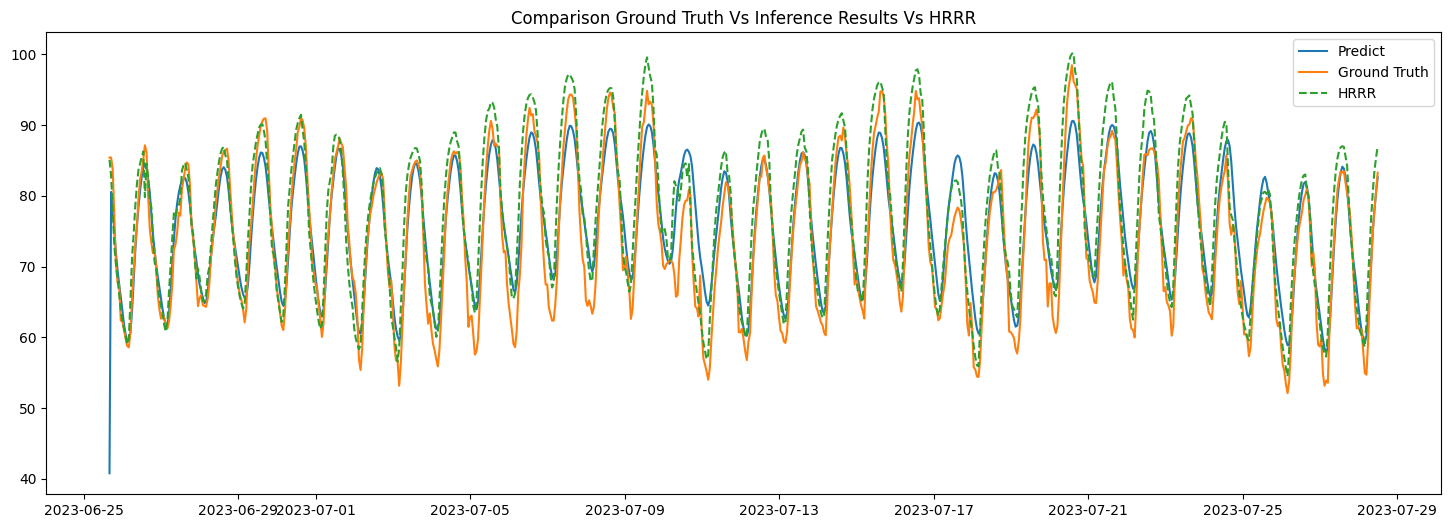

In [12]:
obj_neighbors.view_plot(pred_df, historical_data_path, hrrr_data_path)

In [13]:
obj_neighbors.view_performance(pred_df, historical_data_path, hrrr_data_path)

GNN  temperature
RMSE: 3.98
MAE: 3.19
MAE%: 4.22%

Hrrr temperature
RMSE: 4.64
MAE: 3.8
MAE%: 4.91%


## Step 5: Inference
For weather stations used in GNN model training, we will perform the steps below to get inference results.

**5.1 Download data**
- Download historical weather data for the stations Royal Slope and Ringold from [AGWeatherNet]( https://weather.wsu.edu/) for the time range interested in.

Note: To perform the inference for 24 hours with 60 minutes interval, the minimum data required for 528 hours, similarly If the data frequency is 15 minutes, the minimum number of data points required is 528*4 = 2112. These are the minimum number of data points need to be provided as input during the inference.

**5.2 Preprocessing**
- For each weather station, historical and HRRR data are concatenated by timestamp.
- Data processing is done using Wavelet Transformation techniques. 
- For each weather station, using the trained DeepMC model, we run the inference to find weather forecasts.
- Embeddings are created by combining HRRR data and the predicted weather forecasts.

**5.3 Run GNN model inference**

Finally, we plot the results and calculate KPIs.

### 5.1 Download data

Download AgWeatherNet data and clean it. See [sample data](sample_data.csv).

In [14]:
# weather dataset filtered and model training limited to train features.
HISTORICAL_MODEL_TRAIN_FEATURES = ["humidity", "wind_speed", "temperature"]

# Historical data aligned using INDEX variable
INDEX = "date"

# weather dataset filtered and model training limited to train features.
FORECAST_MODEL_TRAIN_FEATURES = ["humidity_forecast", "wind_speed_forecast", "temperature_forecast"]

# Models trained to predict out features
OUT_FEATURES = ["temperature"]  # ['wind_speed' , 'temperature']

In [15]:
# Get actual observations data for a station, '%s' is a place holder for station name.
file_path = f"<Path>/%s/prediction.csv"

In [16]:
# time range interested in
start_date = datetime(year=2022, month=7, day=1, hour=0, minute=0, second=0)
end_date = datetime(year=2022, month=8, day=15, hour=0, minute=0, second=0)

In [17]:
forecast_data = download_forecast_data(neighbor_stations, start_date, end_date)

Execution status for temperature: done
Execution status for humidity: done
Execution status for u-component: done
Execution status for v-component: done


### 5.2 Preprocessing

Steps to derive embeddings:

- We perform wavelet transformation on selected weather variables (historical and forecast data). 
- The preprocessed output is used as input to run the inference using the DeepMC trained model. The inference results are weather forecasts for neighboring stations.
- The DeepMC inference results are concatenated with HRRR forecast data to create embeddings.

In [18]:
obj_neighbors = MC_Neighbors(root_dir=ROOT_PATH, learning_rate=0.0025, use_edge_weights=False)

In [19]:
embeddings = obj_neighbors.get_embeddings_inference(
    INFERENCE_STATION,
    neighbor_stations,
    24,
    infer_forecast_data_path,
    OUT_FEATURES,
    file_path,
    forecast_data,
    start_date,
    end_date,
)

### 5.3 Run inference

The inference results are weather forecast for stations that are missing station data.

In [20]:
pred_df = obj_neighbors.run_inference(
    embeddings=embeddings.copy(),
    neighbors_station=neighbor_stations,
    infer_station=INFERENCE_STATION,
    batch_size=len(neighbor_stations),
    forecast_hours=24,
)

### 5.4 Plot results and calculate KPIs

- historical_data_path: it's a path to historical weather data downloaded and cleaned in Step 5.1.
- hrrr_data_path: it's a path to hrr weather data downloaded and cleaned in Step 5.1.

In [21]:
historical_data_path = "<Path>"
hrrr_data_path = "<Path>"

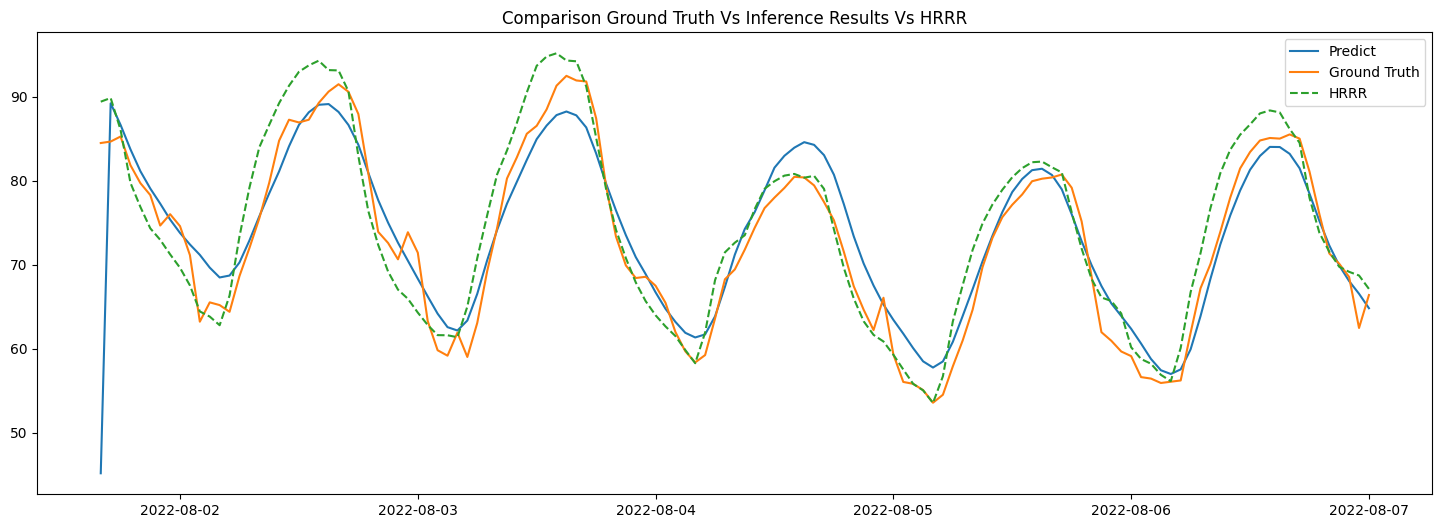

In [22]:
obj_neighbors.view_plot(pred_df, historical_data_path, hrrr_data_path)

In [23]:
obj_neighbors.view_performance(pred_df, historical_data_path, hrrr_data_path)

GNN  temperature
RMSE: 3.05
MAE: 2.57
MAE%: 3.48%

Hrrr temperature
RMSE: 3.72
MAE: 3.02
MAE%: 4.05%
